### Simple model without horizon and location
$y_t \mid \varepsilon_t = \theta + \sum_{p=1} \phi_p y_{t-p} + \varepsilon_t, \\
\varepsilon_t \sim N(0, \sigma_{\eta}) $


In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

import numpy as np
import pandas as pd
import matplotlib
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date

import jax
import jax.numpy as jnp

import arviz as az


In [2]:
from arhdfa_l1h1 import ARHDFA

In [3]:
os.getcwd()

'/Users/dk29776/Dropbox/epi/Comparing-Forecast-Performance/DFA'

In [4]:
def loaddata(model1, model2, val, mean_axis):
    mypath = f'/Users/dk29776/Dropbox/epi/Comparing-Forecast-Performance/Data/death_diff_scores/{model1}_{model2}.csv'
    df = pd.read_csv(mypath)
    lix = pd.MultiIndex.from_product([np.unique(df.location), np.unique(df.relative_horizon)])
    df_pivot = (df.pivot_table(val, 'reference_date', ['location', 'relative_horizon'], aggfunc='first')).reindex(lix, axis=1)
    mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
    if model1 == 'COVIDhub-baseline' or model2 == 'COVIDhub-baseline':
        indices_to_change = [(38, 13), (21, 24), (24, 41)]
        for index in indices_to_change:
            mydf = mydf.at[index[0], index[1], :].set(np.nan) 
        print(mydf[38,13,:])
    if mean_axis == 'location':
        mydf_mean = np.mean(mydf, axis=1)
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],1,mydf_mean.shape[1])
    elif mean_axis == 'horizon':
        mydf_mean = np.mean(mydf, axis=2)
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],mydf_mean.shape[1],1)
    elif mean_axis == 'both':
        mydf_mean = np.mean(mydf, axis=(1,2))
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],1,1)
    return mydf_reshape

In [5]:
obs = loaddata('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both')
print(obs.shape)

/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_27927/539687863.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())


[nan nan nan nan]
(42, 1, 1)


In [6]:
# Define a DFA model with specified parameter values to use for data generation
dfa_model_constant = ARHDFA(num_timesteps=obs.shape[0], num_series=obs.shape[1], num_horizons=obs.shape[2], 
                    p=1, q=1, ar_constraint='[0,1]', sigma_time='constant',
                    ar_var_constraint='[0,1]')


In [7]:
mcmc_samples_constant = dfa_model_constant.fit(y=obs,
                             rng_key=jax.random.PRNGKey(79942),
                             num_warmup=5000,
                             num_samples=5000,
                             thinning = 1,
                             num_chains=3)


/Users/dk29776/Dropbox/epi/Comparing-Forecast-Performance/DFA/arhdfa_l1h1.py:384: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(


(1,)
(1,)


  0%|          | 0/2000 [00:00<?, ?it/s]

(1,)


sample: 100%|██████████| 2000/2000 [00:03<00:00, 554.35it/s, 31 steps of size 6.32e-02. acc. prob=0.69] 


(1,)
(1,)


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1718.65it/s, 15 steps of size 8.04e-02. acc. prob=0.72]


(1,)
(1,)


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1940.95it/s, 63 steps of size 7.54e-02. acc. prob=0.68]



MCMC elapsed time: 9.458226203918457


In [8]:
dfa_model_constant.mcmc.print_summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
       ARVar_mu[0,0]     -0.84      0.95     -0.90     -2.53      0.48    261.59      1.00
          alpha[0,0]      0.54      0.29      0.55      0.12      1.00    301.80      1.01
            beta0[0]      0.81      0.92      0.77     -0.74      2.32    474.81      1.00
            beta1[0]     -1.46      0.72     -1.52     -2.63     -0.36    540.57      1.00
        intercept[0]    -19.08      0.28    -19.10    -19.53    -18.58     45.14      1.08
  log_sigma_eps_t[0]      4.83      0.03      4.83      4.77      4.89    333.42      1.03
log_sigma_eta_0[0,0]      0.81      0.61      0.66      0.00      1.67    325.95      1.01
log_sigma_eta_t[0,0]     -2.02      0.54     -2.03     -2.92     -1.17     60.29      1.05
            phi[0,0]      0.06      0.05      0.05      0.00      0.13    113.57      1.02
         sigma_nu[0]      0.96      0.58      0.89      0.04      1.73    595.65      1.0

In [9]:
az.waic(az.from_numpyro(mcmc_samples_constant))

(1,)
(1,)


Computed from 3000 posterior samples and 1764 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6759.39    22.73
p_waic        2.40        -

In [10]:
idata = az.from_numpyro(mcmc_samples_constant)
idata

(1,)
(1,)


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

(1,)
(1,)


/Users/dk29776/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='alpha\n0, 0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta0\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta1\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='intercept\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log_sigma_eps_t\n0'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log_sigma_eta_0\n0, 0'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log_sigma_eta_t\n0, 0'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='ARVar_mu\n0, 0', ylabel='phi\n0, 0'>,
        <Axes: xlabel='alpha\n0, 0'>, <Axes: xlabel='beta0\n0'>,
        <Axes: xlabel='beta1\n0'>

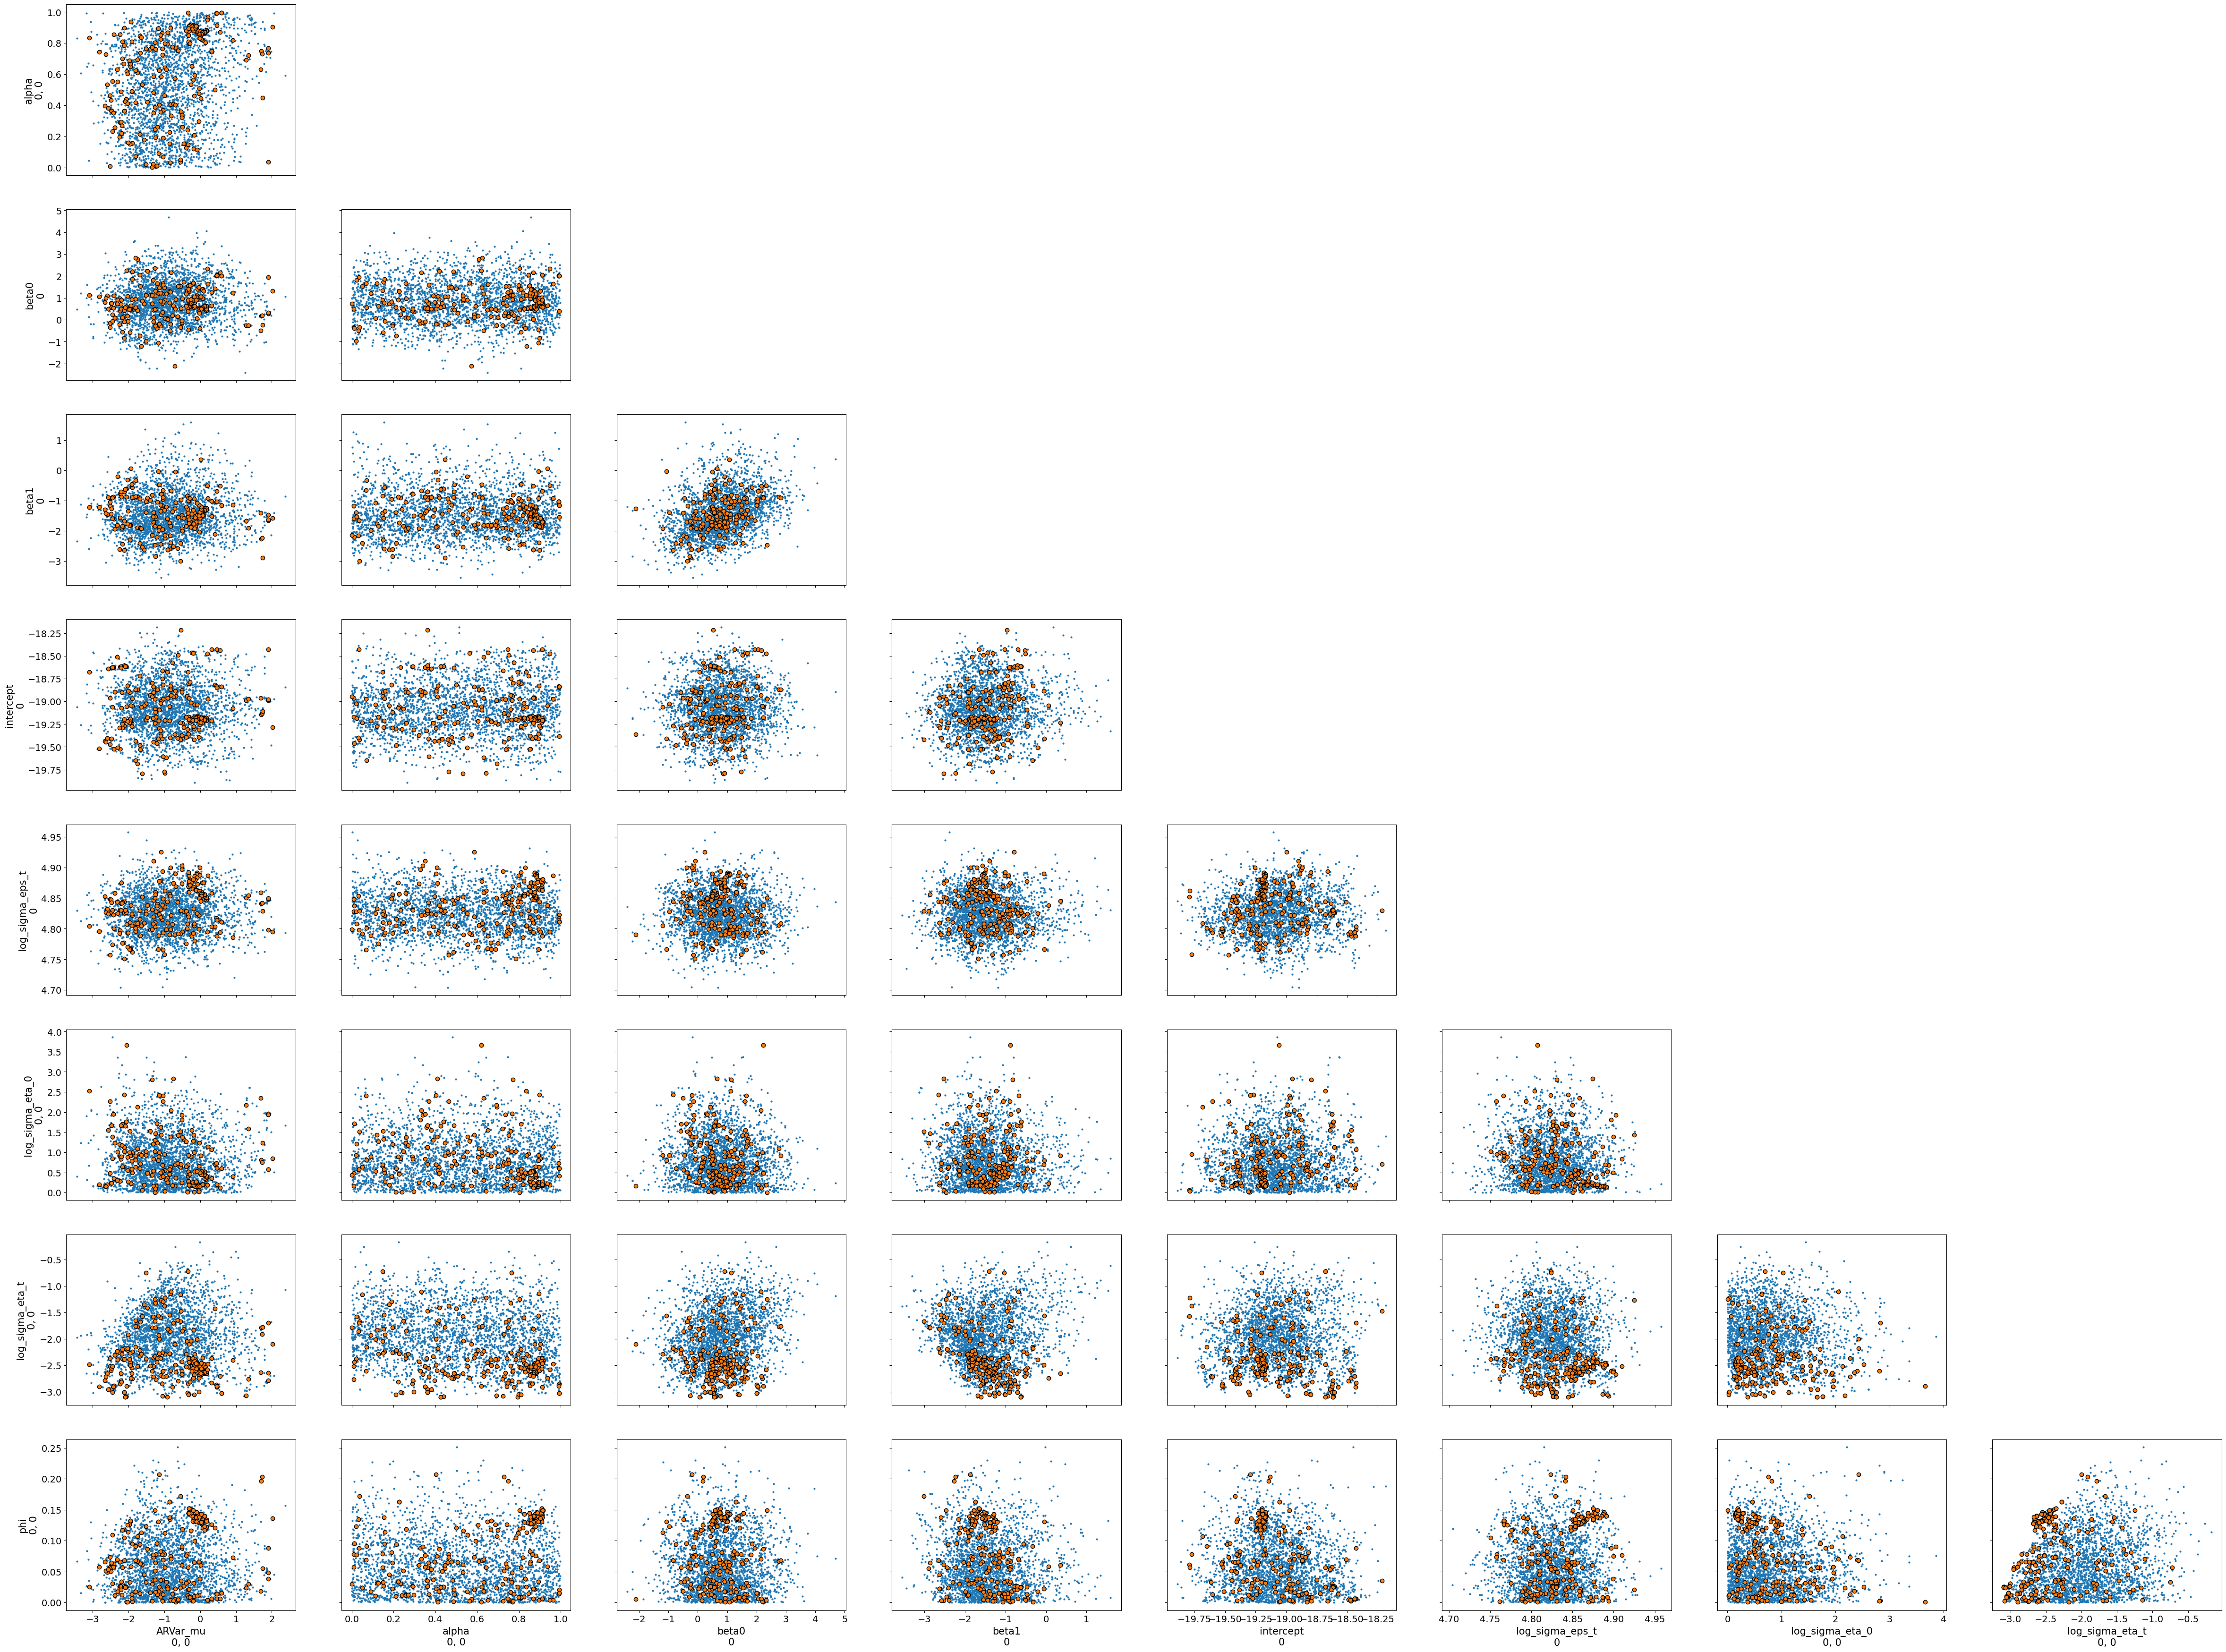

In [11]:
az.plot_pair(az.from_numpyro(mcmc_samples_constant), 
             divergences=True,
             colorbar=True)

(1,)
(1,)


array([[<Axes: >, None],
       [<Axes: xlabel='intercept\n0', ylabel='phi\n0, 0'>, <Axes: >]],
      dtype=object)

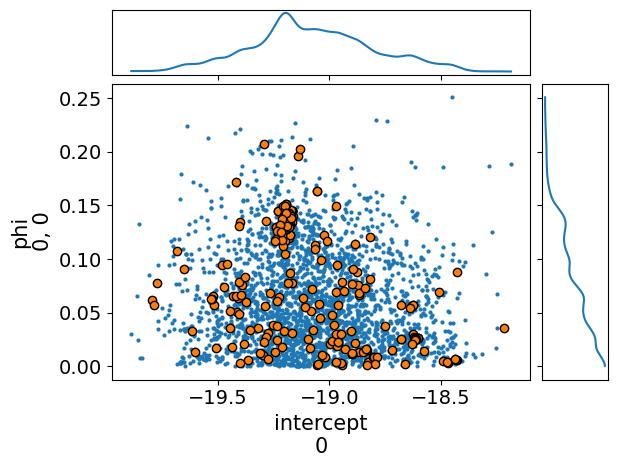

In [12]:
az.plot_pair(az.from_numpyro(mcmc_samples_constant),
             var_names=['phi', 'intercept'],
             filter_vars="regex",
             marginals='True',
             divergences='True',
             colorbar=True)

(1,)
(1,)


array([[<Axes: title={'center': 'ARVar_mu'}>,
        <Axes: title={'center': 'ARVar_mu'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'log_sigma_eps_t'}>,
        <Axes: title={'center': 'log_sigma_eps_t'}>],
       [<Axes: title={'center': 'log_sigma_eta_0'}>,
        <Axes: title={'center': 'log_sigma_eta_0'}>],
       [<Axes: title={'center': 'log_sigma_eta_t'}>,
        <Axes: title={'center': 'log_sigma_eta_t'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'sigma_nu'}>,
        <Axes: title={'center': 'sigma_nu'}>],
       [<Axes: title={'center': 'sigma_zeta'}>,
        <Axes:

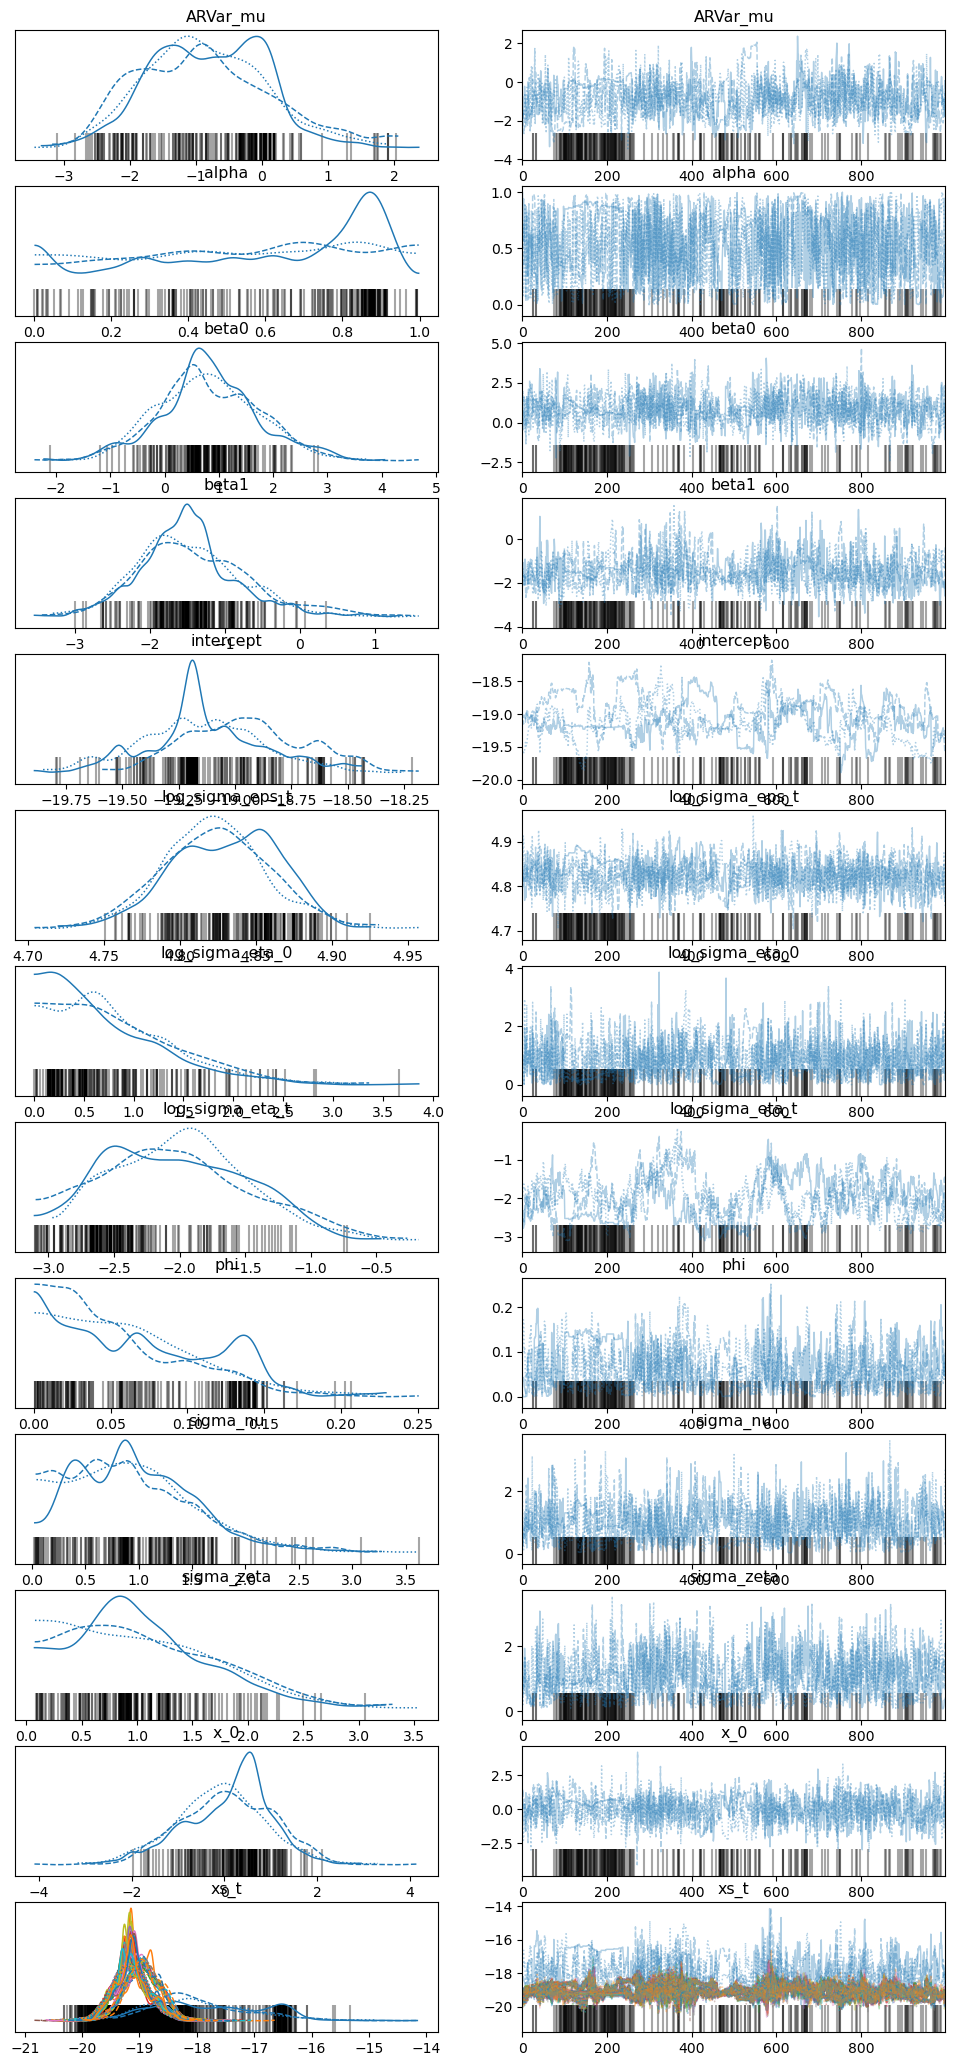

In [13]:
az.plot_trace(az.from_numpyro(mcmc_samples_constant))


In [14]:
print(np.mean(mcmc_samples_constant.get_samples()['intercept']))
print(np.quantile(mcmc_samples_constant.get_samples()['intercept'], [0.025,0.975]))

-19.076057
[-19.62765694 -18.48992872]


In [15]:
# Define a DFA model with specified parameter values to use for data generation
dfa_model = ARHDFA(num_timesteps=obs.shape[0], num_series=obs.shape[1], num_horizons=obs.shape[2], 
                    p=3, q=3, ar_constraint='[0,1]', sigma_time='AR',
                    ar_var_constraint='[0,1]')


In [16]:
mcmc_samples = dfa_model.fit(y=obs,
                             rng_key=jax.random.PRNGKey(79942),
                             num_warmup=5000,
                             num_samples=5000,
                             thinning = 1,
                             num_chains=3)


/Users/dk29776/Dropbox/epi/Comparing-Forecast-Performance/DFA/arhdfa_l1h1.py:384: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(


(42, 1)
(42, 1)


  0%|          | 0/2000 [00:00<?, ?it/s]

(42, 1)


sample: 100%|██████████| 2000/2000 [00:07<00:00, 257.25it/s, 31 steps of size 6.62e-02. acc. prob=0.73] 


(42, 1)
(42, 1)


sample: 100%|██████████| 2000/2000 [00:13<00:00, 144.15it/s, 127 steps of size 3.61e-02. acc. prob=0.84]


(42, 1)
(42, 1)


sample: 100%|██████████| 2000/2000 [00:07<00:00, 274.77it/s, 127 steps of size 5.32e-02. acc. prob=0.73]



MCMC elapsed time: 31.968307971954346


In [24]:
az.waic(az.from_numpyro(mcmc_samples))

(42, 1)
(42, 1)


Computed from 3000 posterior samples and 1764 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6762.26    22.81
p_waic        4.82        -

In [17]:
dfa_model.mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
        ARVar_mu[0,0]     -1.31      0.78     -1.40     -2.54     -0.26    139.22      1.02
           alpha[0,0]      0.25      0.19      0.20      0.00      0.53    388.86      1.00
           alpha[0,1]      0.22      0.18      0.17      0.00      0.47    589.82      1.01
           alpha[0,2]      0.21      0.16      0.17      0.00      0.45    385.99      1.01
             beta0[0]      1.09      1.00      1.07     -0.66      2.63    368.85      1.02
             beta1[0]      0.01      1.32     -0.02     -2.05      2.30     64.75      1.05
         intercept[0]    -19.09      0.30    -19.10    -19.61    -18.62    102.29      1.02
 log_sigma_eps_t[0,0]      4.82      0.03      4.82      4.78      4.88   1122.82      1.00
 log_sigma_eps_t[1,0]      1.48      2.23      1.53     -1.83      5.43    390.84      1.01
 log_sigma_eps_t[2,0]      1.54      2.46      1.65     -2.19      5.93    183.

(42, 1)
(42, 1)


/Users/dk29776/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='alpha\n0, 0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n0, 1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n0, 2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta0\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta1\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='intercept\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log_sigma_eps_t\n0, 0'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='ARVar_mu\n0, 0', ylabel='log_sigma_eps_t\n1, 0'>,
        <Axes: xlabel='alpha\n0, 0'>, <Axes: xlabel='alpha\n0, 1'>,
        <Axes: xlabel='alpha\n0, 2'

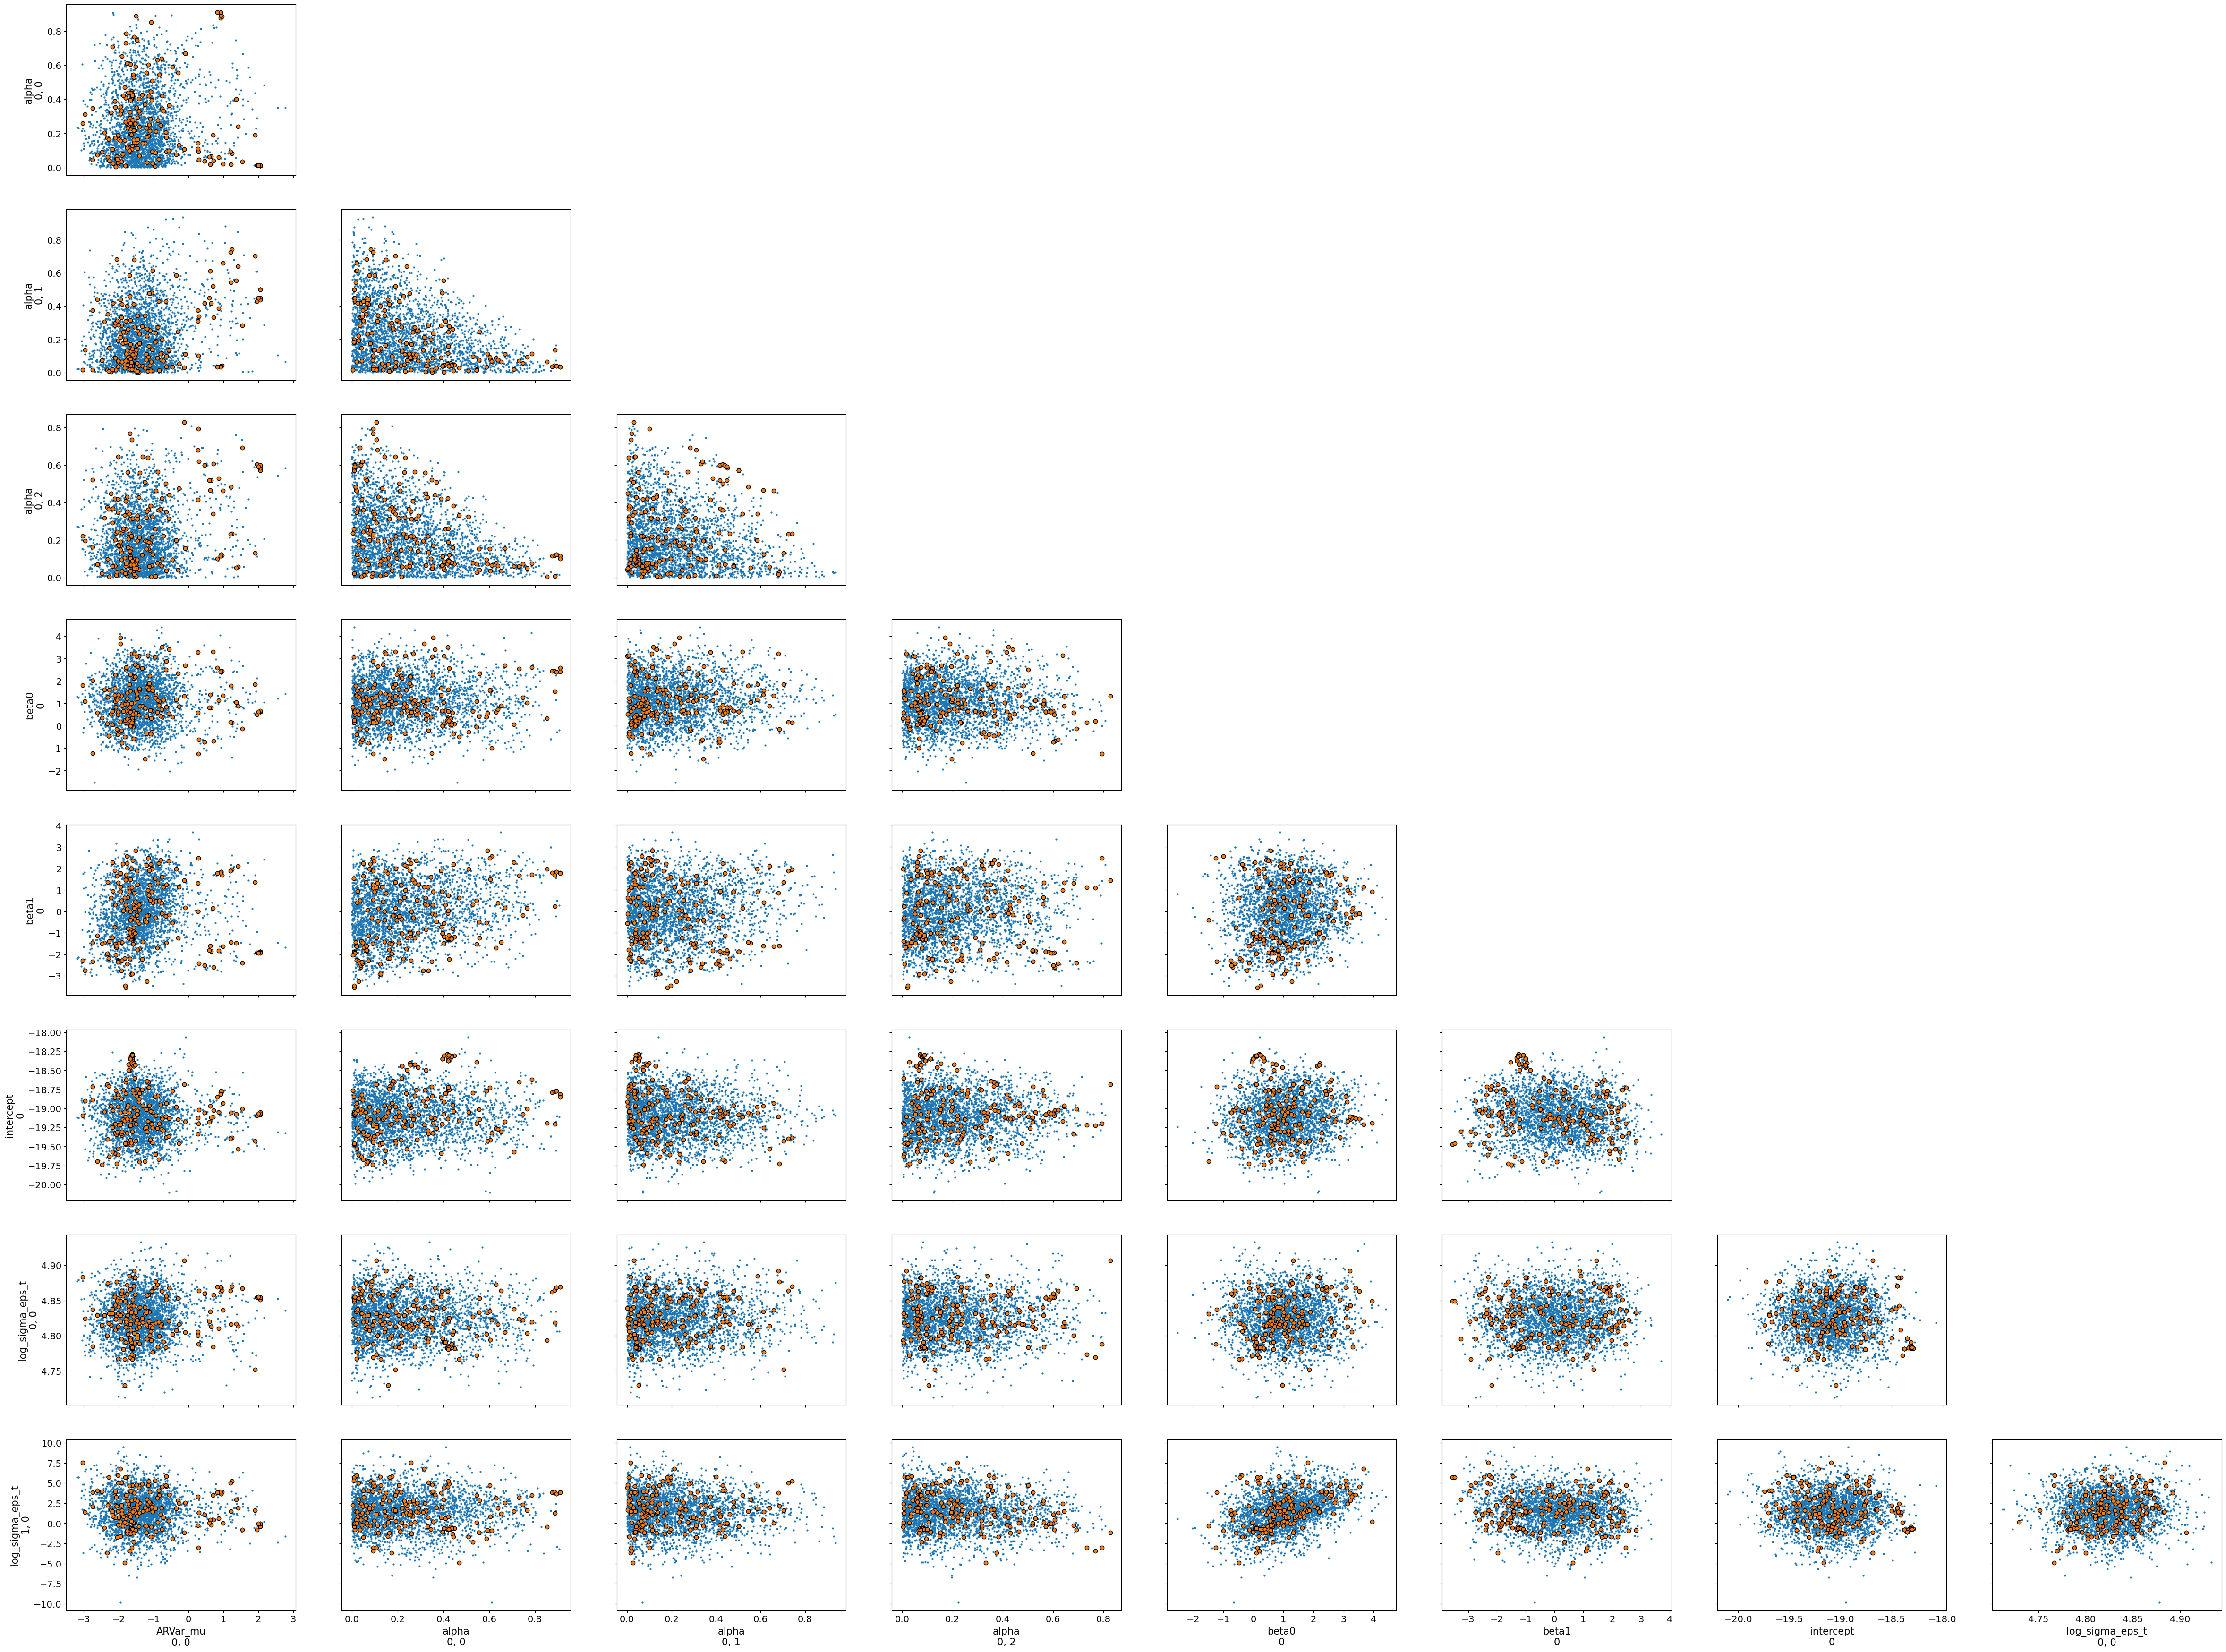

In [18]:
az.plot_pair(az.from_numpyro(mcmc_samples), 
             divergences=True,
             colorbar=True)

(42, 1)
(42, 1)


array([[<Axes: ylabel='intercept\n0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='phi\n0, 0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='phi\n0, 1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='intercept\n0', ylabel='phi\n0, 2'>,
        <Axes: xlabel='phi\n0, 0'>, <Axes: xlabel='phi\n0, 1'>,
        <Axes: xlabel='phi\n0, 2'>]], dtype=object)

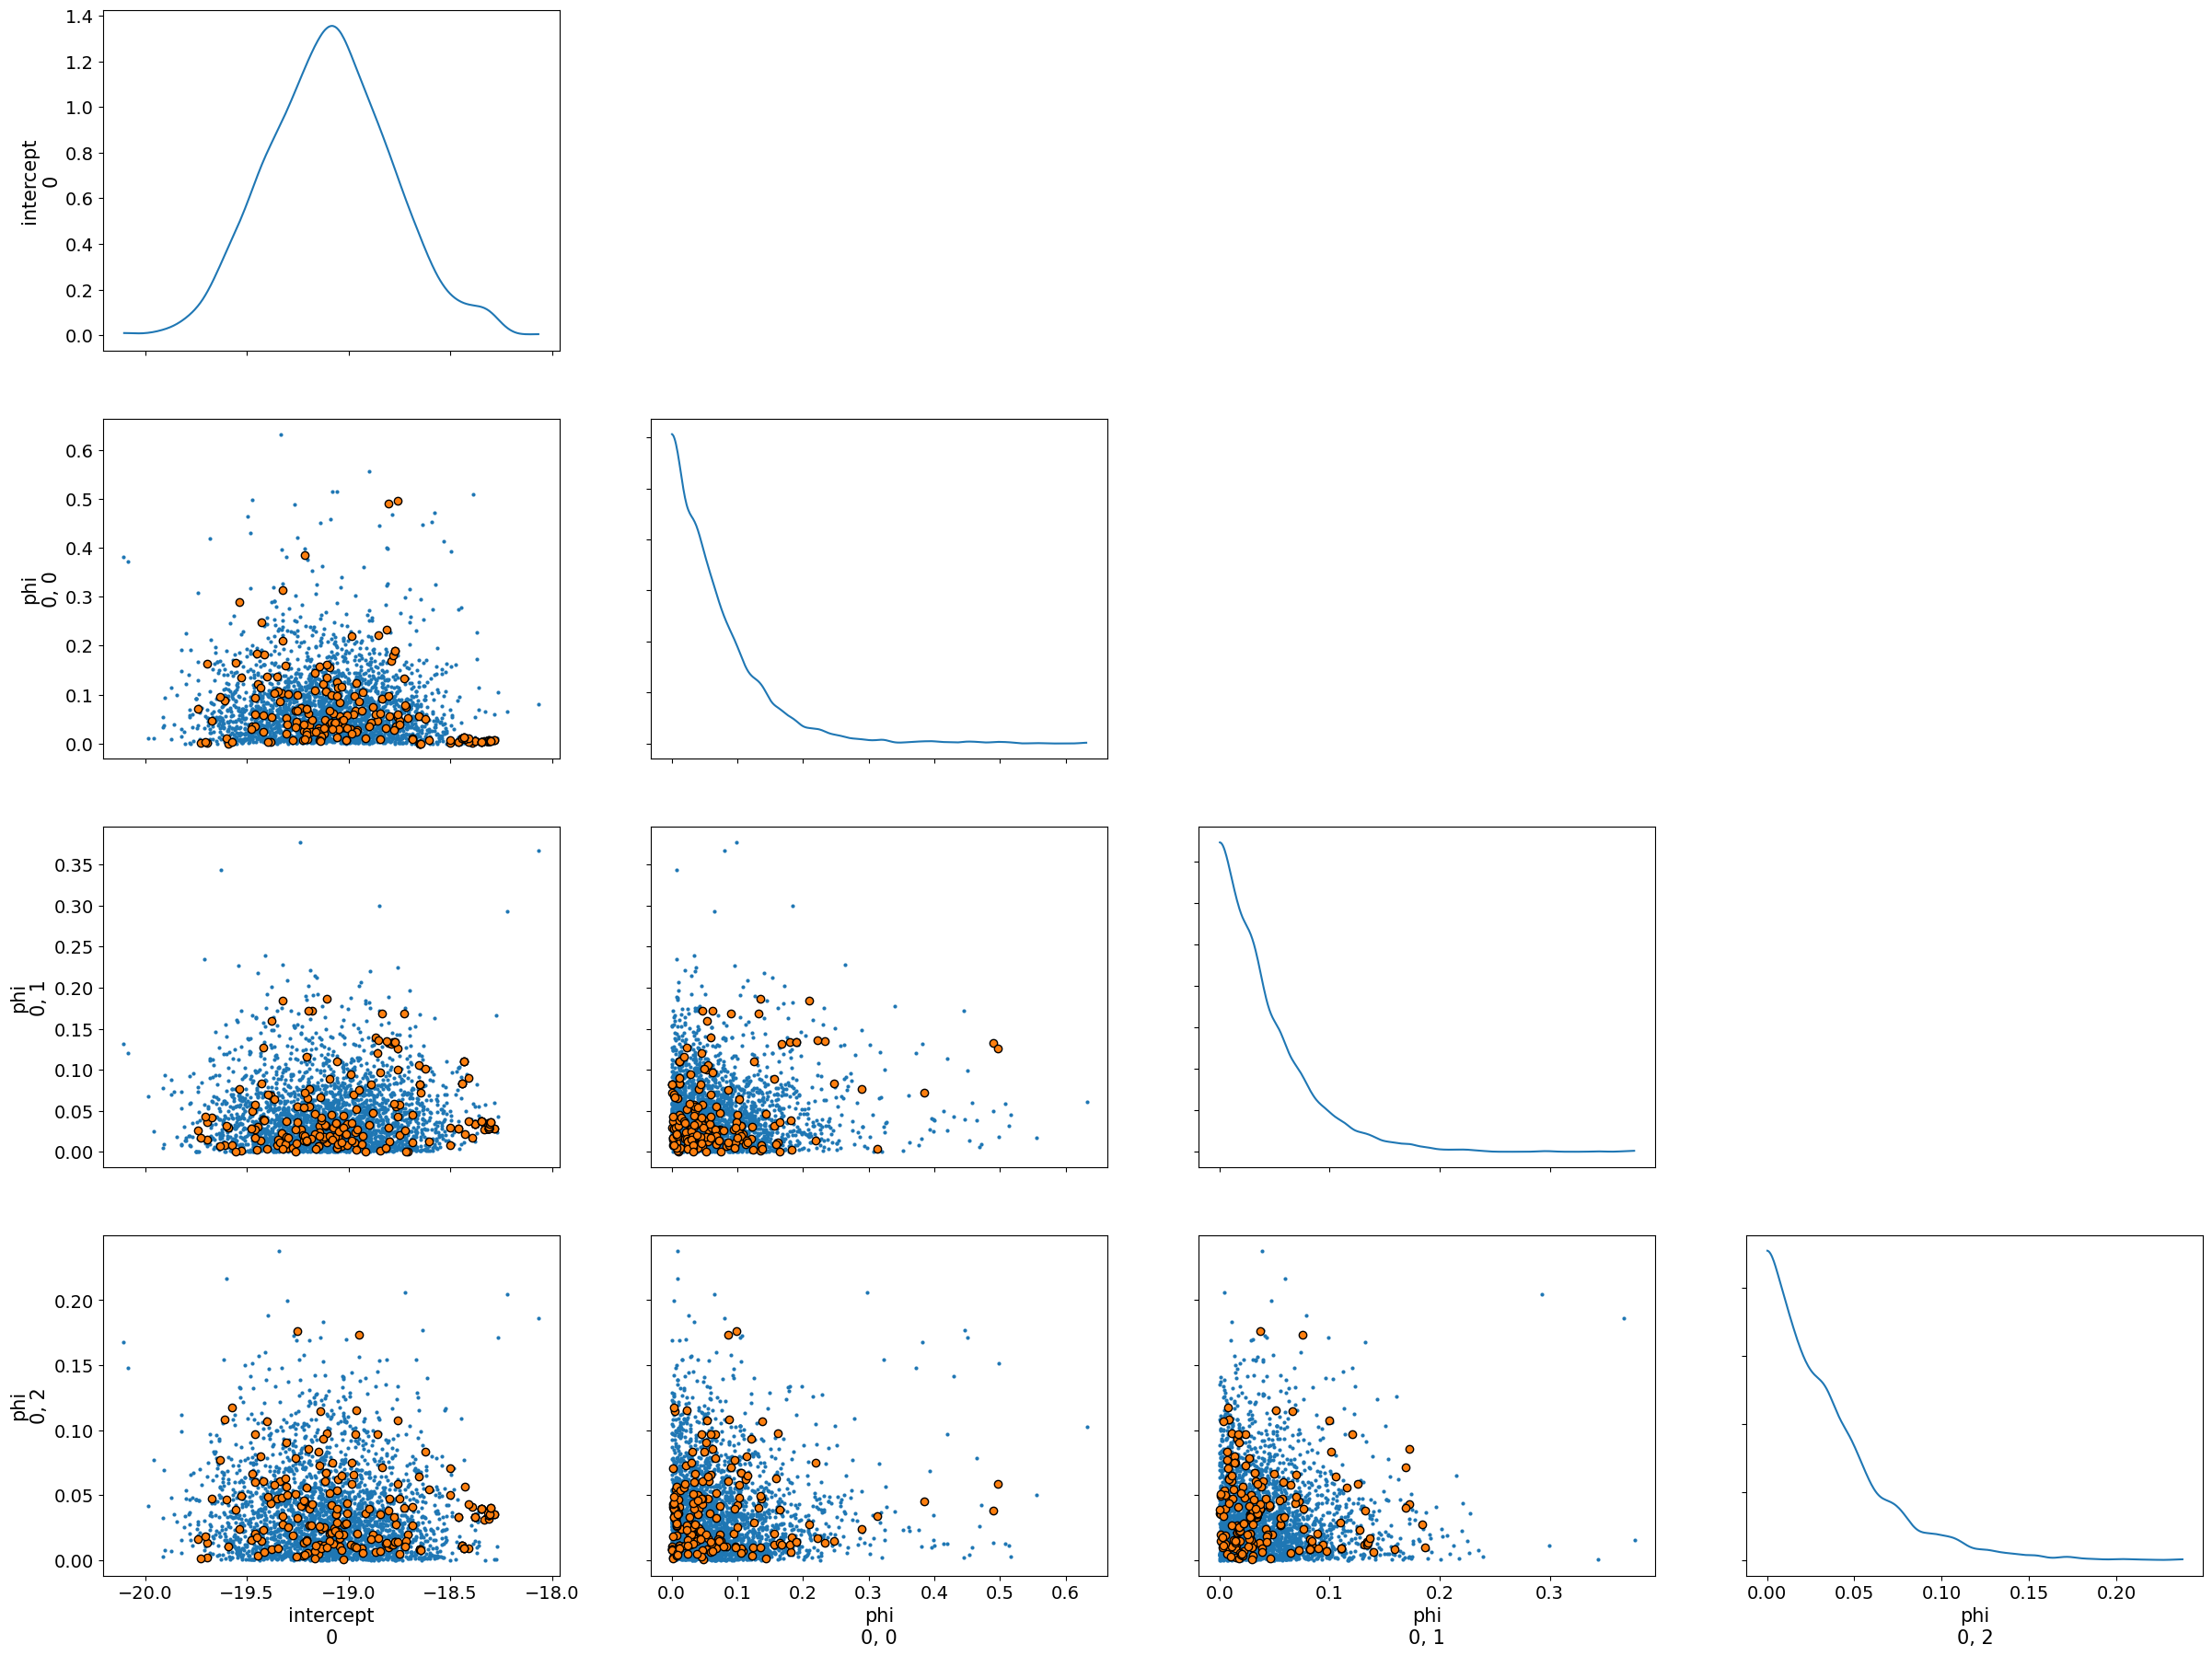

In [22]:
az.plot_pair(az.from_numpyro(mcmc_samples),
             var_names=['phi', 'intercept'],
             filter_vars="regex",
             marginals='True',
             divergences='True',
             colorbar=True)

(42, 1)
(42, 1)


array([[<Axes: title={'center': 'ARVar_mu'}>,
        <Axes: title={'center': 'ARVar_mu'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'log_sigma_eps_t'}>,
        <Axes: title={'center': 'log_sigma_eps_t'}>],
       [<Axes: title={'center': 'log_sigma_eta'}>,
        <Axes: title={'center': 'log_sigma_eta'}>],
       [<Axes: title={'center': 'log_sigma_eta_0'}>,
        <Axes: title={'center': 'log_sigma_eta_0'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'sigma_nu'}>,
        <Axes: title={'center': 'sigma_nu'}>],
       [<Axes: title={'center': 'sigma_zeta'}>,
        <Axes: tit

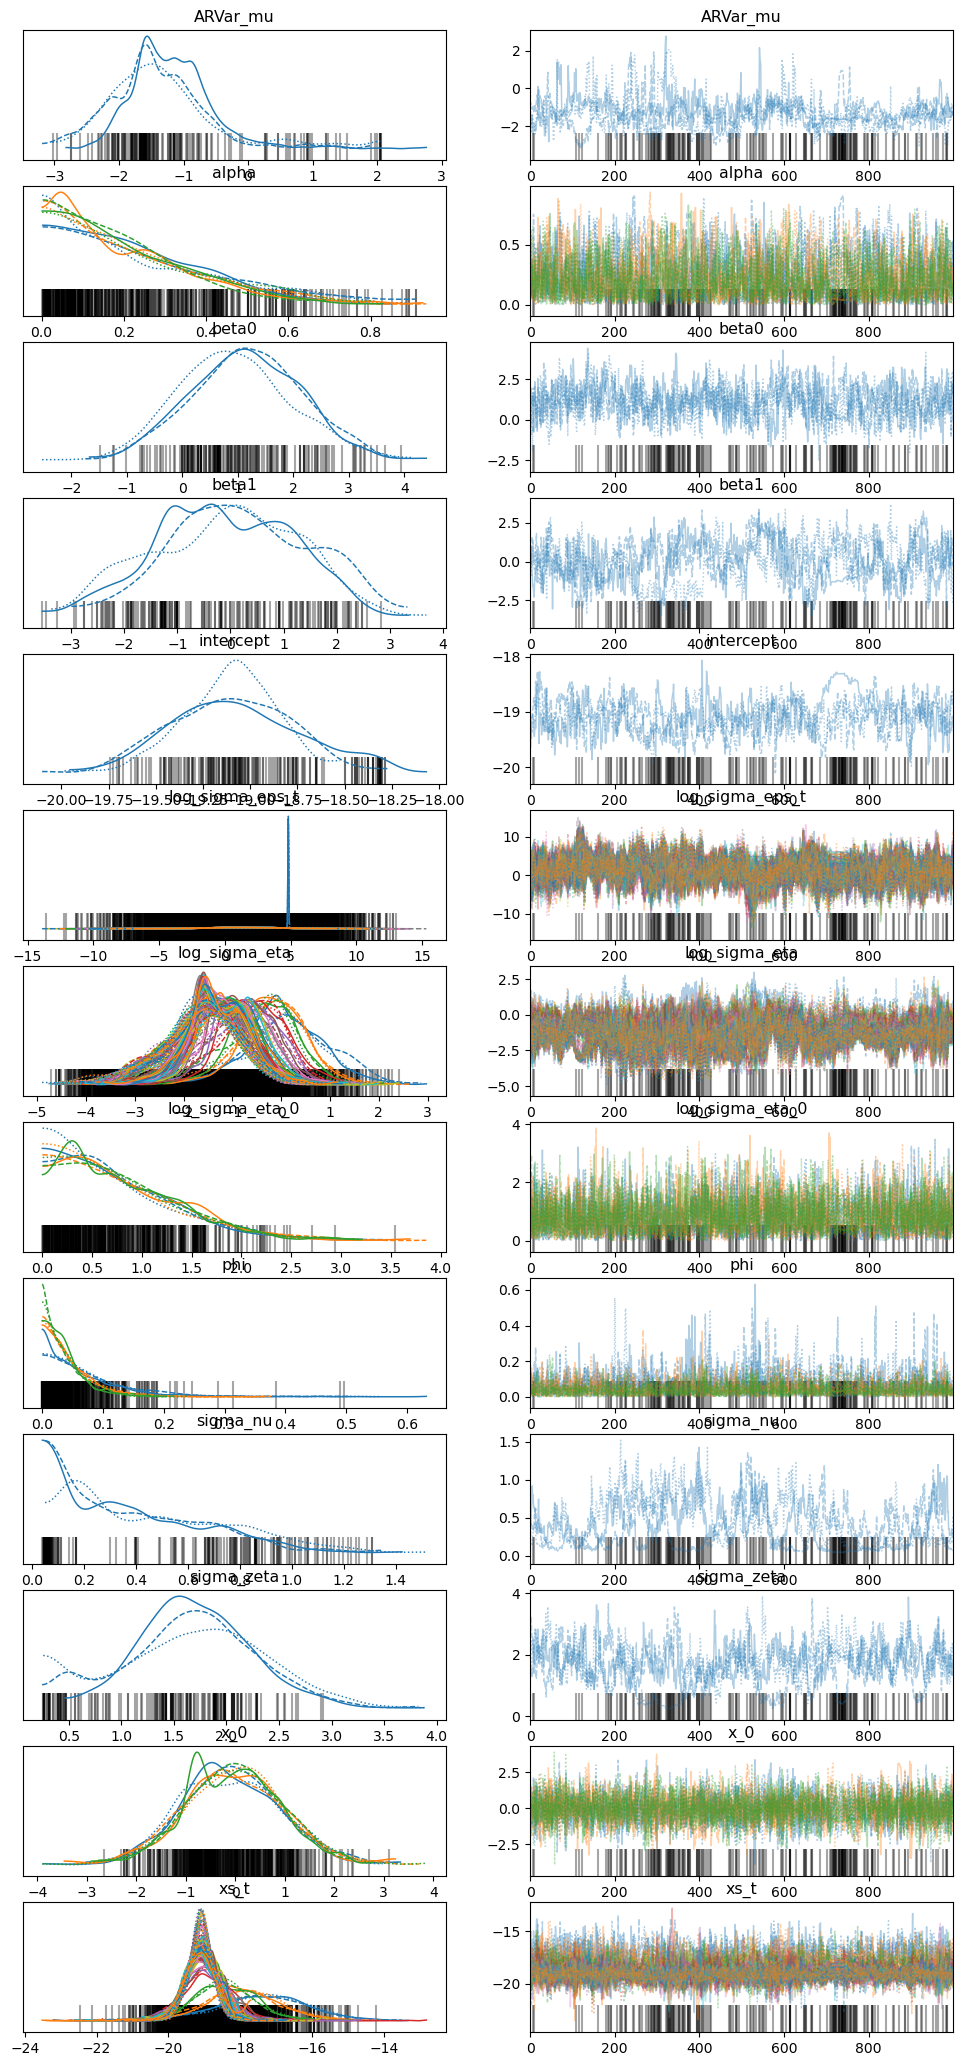

In [23]:
az.plot_trace(az.from_numpyro(mcmc_samples))


In [21]:
print(np.mean(mcmc_samples.get_samples()['intercept']))
print(np.quantile(mcmc_samples.get_samples()['intercept'], [0.025,0.975]))

-19.092926
[-19.66106172 -18.44756489]


In [35]:
param_names = mcmc_samples_constant.get_samples().keys()
n_param_constant = {p:np.squeeze(mcmc_samples_constant.get_samples()[p]).shape[-1] if len(np.squeeze(mcmc_samples_constant.get_samples()[p]).shape) > 1 else 1 \
           for p in param_names}
n_param_constant

{'ARVar_mu': 1,
 'alpha': 1,
 'beta0': 1,
 'beta1': 1,
 'intercept': 1,
 'log_sigma_eps_t': 1,
 'log_sigma_eta_0': 1,
 'log_sigma_eta_t': 1,
 'phi': 1,
 'sigma_nu': 1,
 'sigma_zeta': 1,
 'x_0': 1,
 'xs_t': 42}

In [36]:
param_names = mcmc_samples.get_samples().keys()
n_param = {p:np.squeeze(mcmc_samples.get_samples()[p]).shape[-1] if len(np.squeeze(mcmc_samples.get_samples()[p]).shape) > 1 else 1 \
           for p in param_names}
n_param

{'ARVar_mu': 1,
 'alpha': 3,
 'beta0': 1,
 'beta1': 1,
 'intercept': 1,
 'log_sigma_eps_t': 42,
 'log_sigma_eta': 42,
 'log_sigma_eta_0': 3,
 'phi': 3,
 'sigma_nu': 1,
 'sigma_zeta': 1,
 'x_0': 3,
 'xs_t': 42}